# Background
- **Author**: `<方珮潔>`
- **Created At**: `<2025-11-27>`
- **Path to Training Data： discount-timing-DE.csv**
- **Path to Testing Data： discount-timing-DE.csv**
- **Model Specification 
    - Method：logistic regression
    - Variables：  
    ['Age', 'MultiPlayer', 'PlayerGrowthRate1W', 'FollowersGrowthRate1W', 'PositiveRateGrowthRate1W', 'SalePeriod', 'DiscountFreq3M', 'DLC_sum_1W', 'Sequel_sum_1W']
    - Tuning Parameters：if SMOTE
    - Optimization Method：balance model(SMOTE)
- **Main Findings and Takeaways：**
    - 約 50% 的折扣間隔集中在 30~60 天
    - Lasso 判斷後滯期與變數
        - PlayerGrowthRate1M：1（不合理？）
        - FollowersGrowthRate1M：1
        - PositiveRateGrowthRate2W：15（正相關）
- **Future Direciton：**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## 折扣間隔分佈

總共找到 448 個折扣間隔天數數據點。
平均折扣間隔天數: 45.38 天
中位數折扣間隔天數: 39.00 天


/Users/peijiefang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


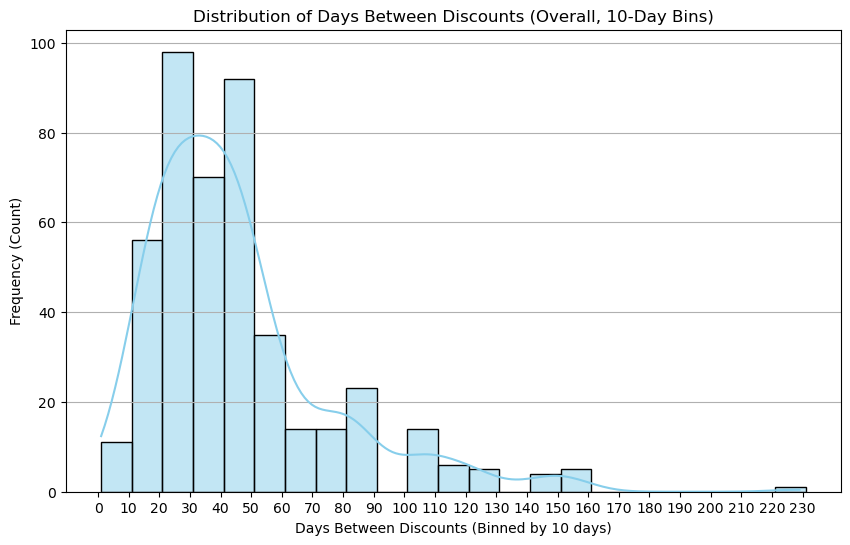

In [40]:
# --- 請替換為您的實際資料載入步驟 ---
# 假設您的資料已經載入到 'df' DataFrame 中
df = pd.read_csv('/Users/peijiefang/Downloads/data analysis project/discount-timing-DE.csv') 

# 確保 Date 欄位是日期格式，並設定為索引 (如果尚未設定)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()
# 確保 DiscountOrNot 欄位是數值類型（0 或 1），方便過濾
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)
# ------------------------------------

# --------------------------------------------------
# 1. 計算每個遊戲的折扣間隔天數 (此部分不變)
# --------------------------------------------------

all_intervals = []

# 按 GameID 分組並迭代
for game_id, group in df.groupby('GameID'):
    # 只選擇有折扣 (DiscountOrNot == 1) 的行
    discount_dates = group[group['DiscountOrNot'] == 1].index
    
    # 計算連續折扣日期之間的時間差 (timedelta)
    intervals = discount_dates.to_series().diff()
    
    # 將 timedelta 轉換為天數的數字
    interval_days = intervals.dt.days.dropna().tolist()
    
    all_intervals.extend(interval_days)

interval_series = pd.Series(all_intervals)

print(f"總共找到 {len(all_intervals)} 個折扣間隔天數數據點。")
print(f"平均折扣間隔天數: {interval_series.mean():.2f} 天")
print(f"中位數折扣間隔天數: {interval_series.median():.2f} 天")

# --------------------------------------------------
# 2. 繪製間隔天數的分佈直方圖 (修改此部分)
# --------------------------------------------------

plt.figure(figsize=(10, 6))

# 使用 seaborn 繪製直方圖，並設定 binwidth=10
sns.histplot(interval_series, binwidth=10, kde=True, color='skyblue')

plt.title('Distribution of Days Between Discounts (Overall, 10-Day Bins)')
plt.xlabel('Days Between Discounts (Binned by 10 days)')
plt.ylabel('Frequency (Count)')
plt.grid(True, axis='y')

# 設定 X 軸刻度為 10 的倍數，使其更清晰
max_days = int(interval_series.max())
plt.xticks(range(0, max_days + 10, 10))

plt.show()

In [42]:
# ... [之前的程式碼，直到計算出 interval_series] ...
# interval_series 是包含所有折扣間隔天數的 Pandas Series

print(f"總共找到 {len(all_intervals)} 個折扣間隔天數數據點。")
print(f"平均折扣間隔天數: {interval_series.mean():.2f} 天")
print(f"中位數折扣間隔天數: {interval_series.median():.2f} 天")

# --------------------------------------------------
# 1. 計算 30 天內折扣間隔的比例
# --------------------------------------------------

# 篩選出所有小於或等於 30 天的間隔
within_30_days = interval_series[interval_series <= 30]

# 計算比例
proportion_within_30d = len(within_30_days) / len(interval_series)
percentage_within_30d = proportion_within_30d * 100

print("-" * 30)
print(f"在 30 天內的折扣間隔數量: {len(within_30_days)} 個")
print(f"佔總體比例: {percentage_within_30d:.2f}%")
print("-" * 30)

# --------------------------------------------------
# 2. 計算 60 天內折扣間隔的比例
# --------------------------------------------------

# 篩選出所有小於或等於 60 天的間隔
within_60_days = interval_series[interval_series <= 60]

# 計算比例
proportion_within_60d = len(within_60_days) / len(interval_series)
percentage_within_60d = proportion_within_60d * 100

print("-" * 30)
print(f"在 60 天內的折扣間隔數量: {len(within_60_days)} 個")
print(f"佔總體比例: {percentage_within_60d:.2f}%")
print("-" * 30)

總共找到 448 個折扣間隔天數數據點。
平均折扣間隔天數: 45.38 天
中位數折扣間隔天數: 39.00 天
------------------------------
在 30 天內的折扣間隔數量: 165 個
佔總體比例: 36.83%
------------------------------
------------------------------
在 60 天內的折扣間隔數量: 362 個
佔總體比例: 80.80%
------------------------------


## PACF 找後滯期數

### PlayerGrowthRate1W

找到 28 個遊戲資料。開始分析...


/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_25624/592820521.py:52: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)


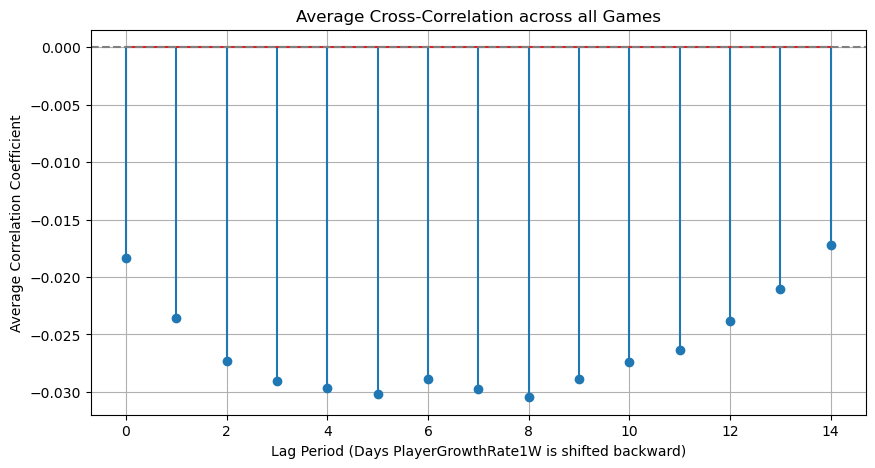


所有遊戲平均相關性最強的滯後期數為: Lag 8 天
您可以考慮將 Lag 8 的 PlayerGrowthRate1W 納入您的單一模型中。


In [3]:
# --------------------------------------------------
# 1. 準備工作：獲取唯一的遊戲 ID 列表
# --------------------------------------------------
game_ids = df['GameID'].unique()
max_lag = 14 # 檢查過去兩週的滯後期數
lag_results = {}

print(f"找到 {len(game_ids)} 個遊戲資料。開始分析...")

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['PlayerGrowthRate1W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['PlayerGrowthRate1W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days PlayerGrowthRate1W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 PlayerGrowthRate1W 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0020

被 Lasso 選中的顯著滯後期數 (非零係數):
  GrowthRate_Lag_1: 係數 = -0.0010
  GrowthRate_Lag_3: 係數 = -0.0004
  GrowthRate_Lag_8: 係數 = -0.0001
  GrowthRate_Lag_11: 係數 = -0.0005
  GrowthRate_Lag_18: 係數 = -0.0002


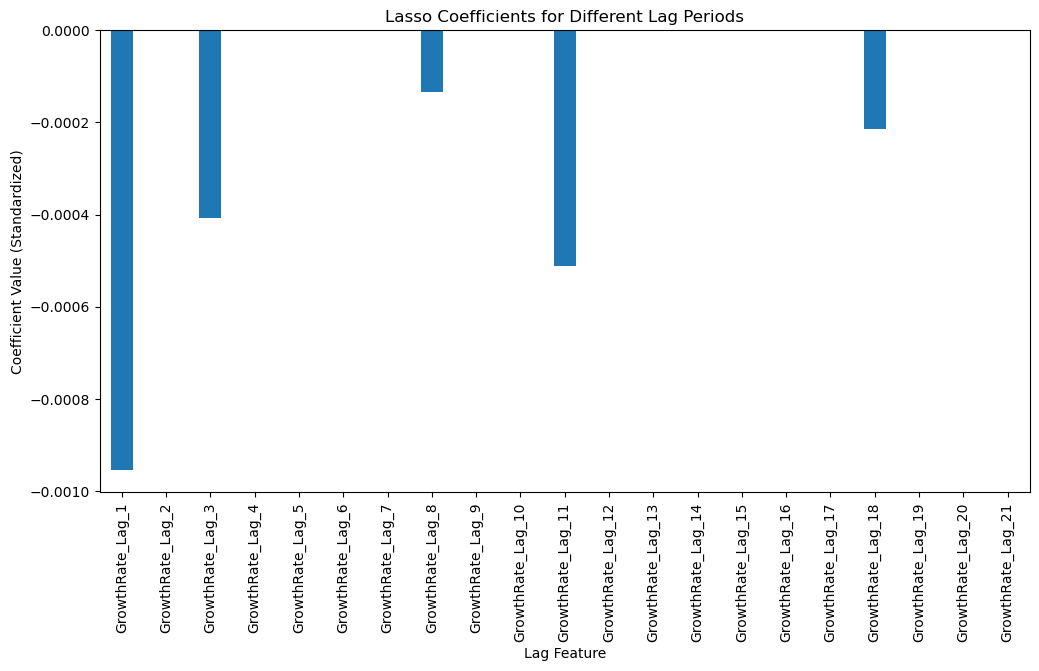

In [32]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['PlayerGrowthRate1W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### PlayerGrowthRate2W

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_25624/897897802.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)


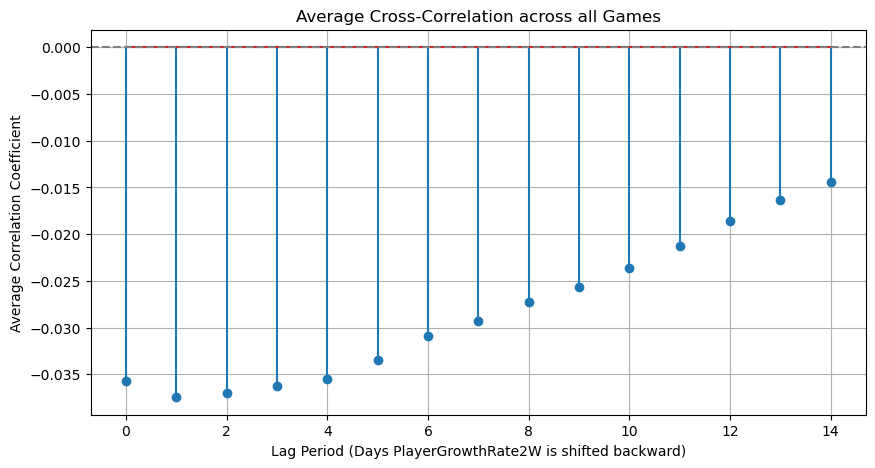


所有遊戲平均相關性最強的滯後期數為: Lag 1 天
您可以考慮將 Lag 1 的 PlayerGrowthRate2W 納入您的單一模型中。


In [5]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['PlayerGrowthRate2W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['PlayerGrowthRate2W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days PlayerGrowthRate2W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 PlayerGrowthRate2W 納入您的單一模型中。")

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008176622251788501, tolerance: 0.006294839537869094
  model = cd_fast.enet_coordinate_descent_gram(
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008309977526728574, tolerance: 0.006294839537869094
  model = cd_fast.enet_coordinate_descent_gram(
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008319081002667872, tolerance: 0.006294839537869094
  model = cd_fast.enet_coordinate_descent_gram(
/Users/peijiefang/anaconda3/lib/py

LassoCV 找到的最佳 alpha 值: 0.0010

被 Lasso 選中的顯著滯後期數 (非零係數):
  GrowthRate_Lag_1: 係數 = -0.0027
  GrowthRate_Lag_11: 係數 = -0.0001
  GrowthRate_Lag_12: 係數 = -0.0014
  GrowthRate_Lag_21: 係數 = 0.0003


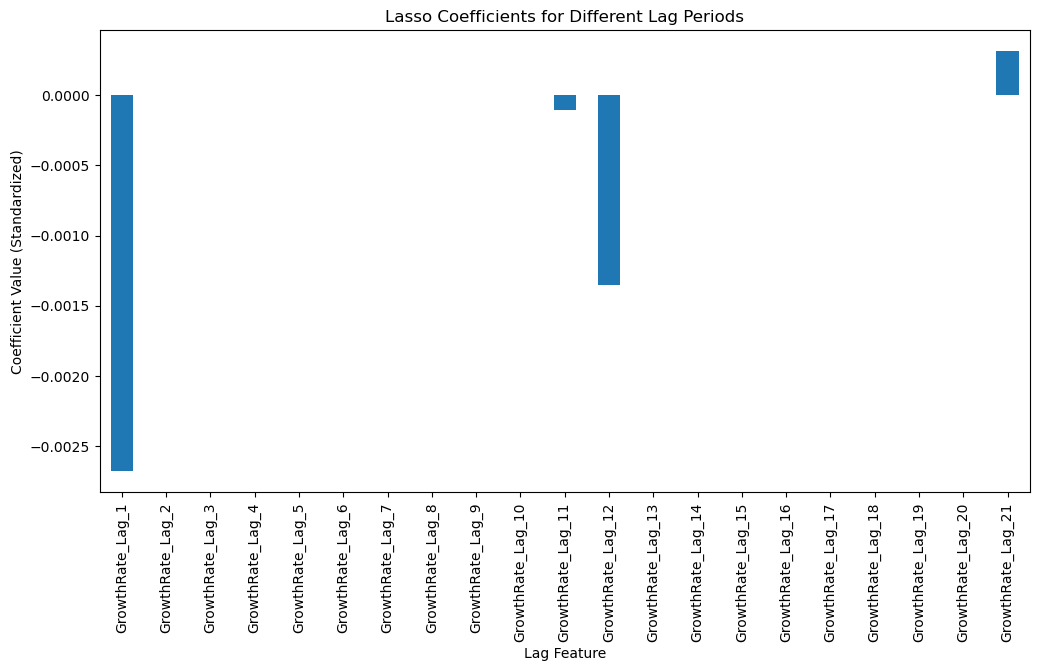

In [30]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['PlayerGrowthRate2W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### PlayerGrowthRate1M*

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_25624/3255478261.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)


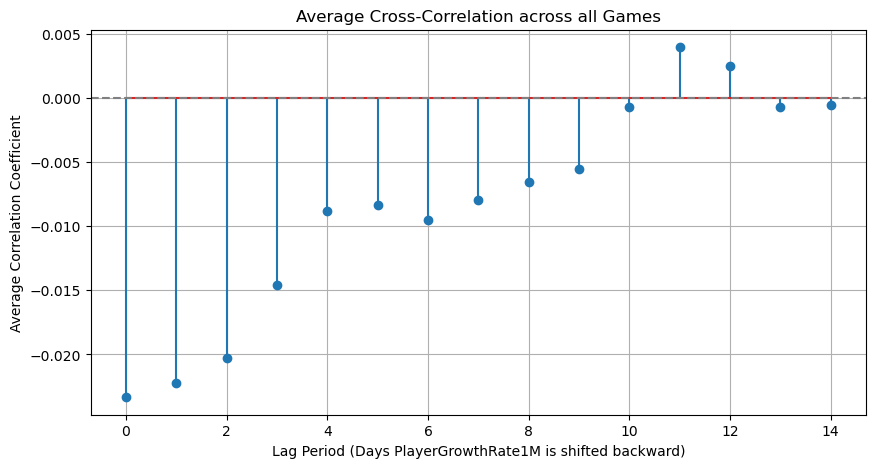


所有遊戲平均相關性最強的滯後期數為: Lag 0 天
您可以考慮將 Lag 0 的 PlayerGrowthRate1M 納入您的單一模型中。


In [6]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['PlayerGrowthRate1M']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['PlayerGrowthRate1M'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days PlayerGrowthRate1M is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 PlayerGrowthRate1M 納入您的單一模型中。")

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011097450109296858, tolerance: 0.006294839537869094
  model = cd_fast.enet_coordinate_descent_gram(
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018150733255154705, tolerance: 0.006294839537869094
  model = cd_fast.enet_coordinate_descent_gram(
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022098201614177526, tolerance: 0.006294839537869094
  model = cd_fast.enet_coordinate_descent_gram(
/Users/peijiefang/anaconda3/lib/py

LassoCV 找到的最佳 alpha 值: 0.0004

被 Lasso 選中的顯著滯後期數 (非零係數):
  GrowthRate_Lag_1: 係數 = -0.0074
  GrowthRate_Lag_4: 係數 = 0.0032
  GrowthRate_Lag_11: 係數 = 0.0035
  GrowthRate_Lag_21: 係數 = -0.0002


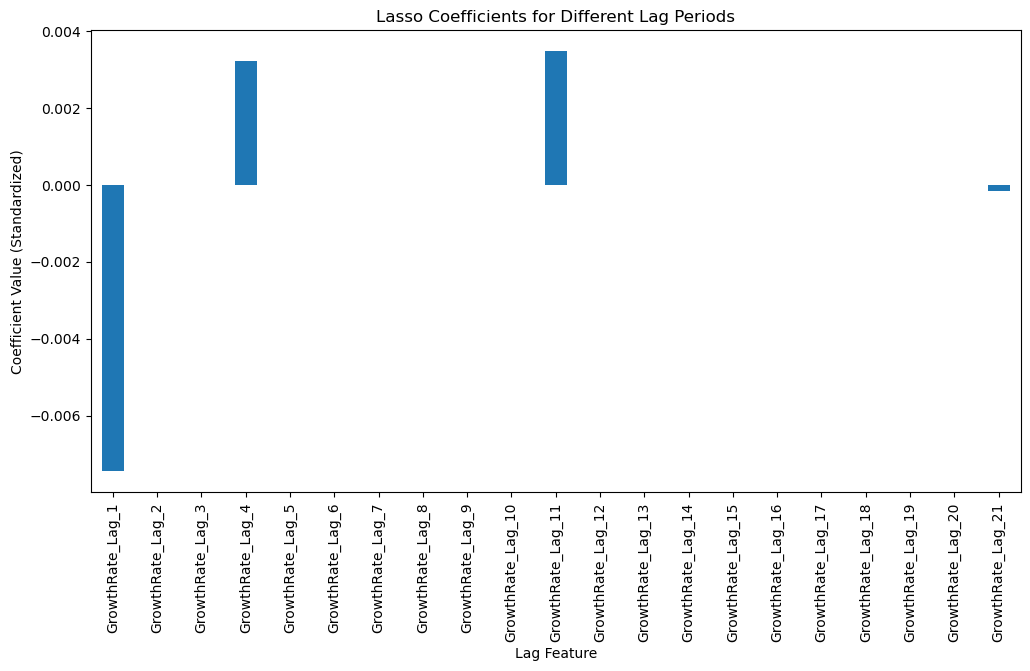

In [29]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['PlayerGrowthRate1M'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### FollowersGrowthRate1W

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_25624/4123839303.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)


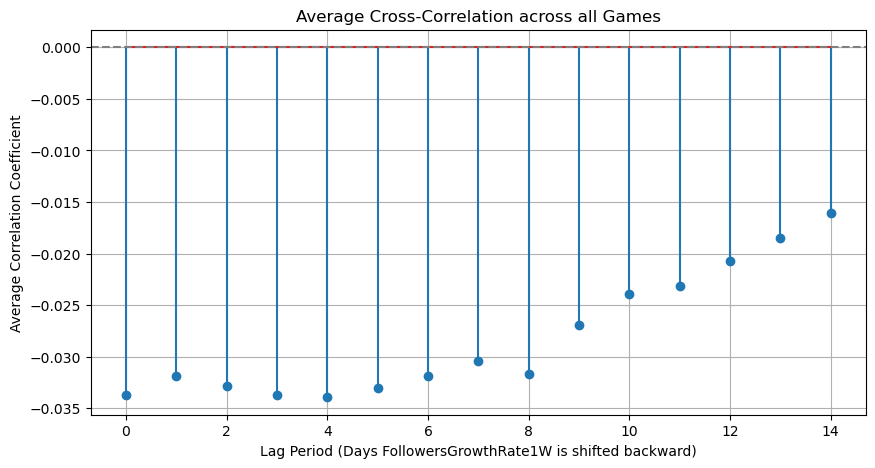


所有遊戲平均相關性最強的滯後期數為: Lag 4 天
您可以考慮將 Lag 4 的 FollowersGrowthRate1W 納入您的單一模型中。


In [4]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['FollowersGrowthRate1W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['FollowersGrowthRate1W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days FollowersGrowthRate1W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 FollowersGrowthRate1W 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0013

被 Lasso 選中的顯著滯後期數 (非零係數):
  GrowthRate_Lag_1: 係數 = -0.0033
  GrowthRate_Lag_8: 係數 = -0.0015


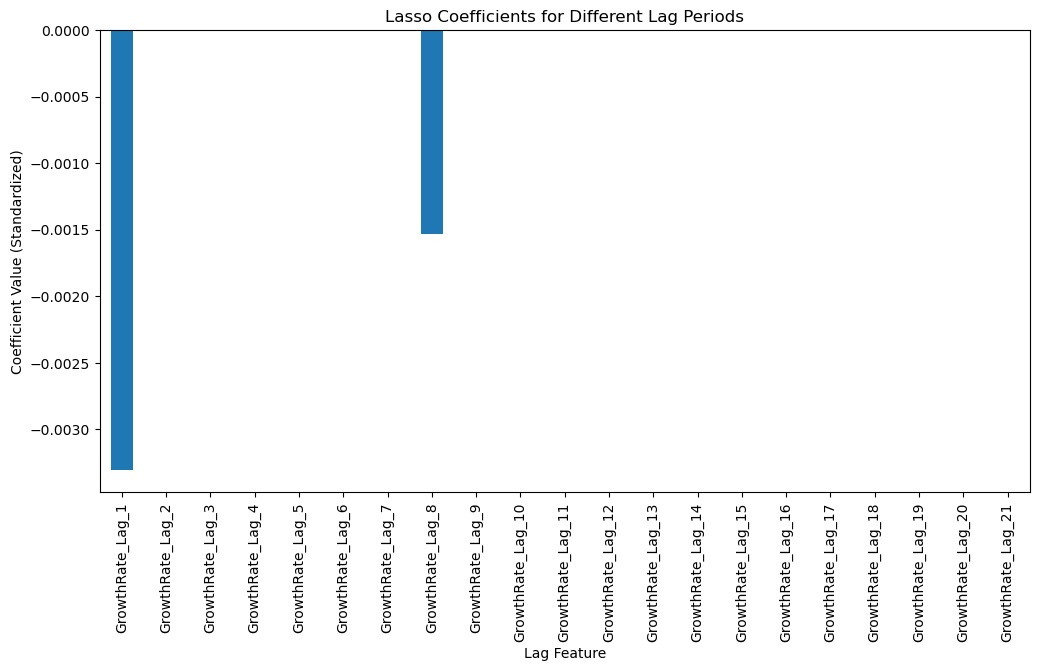

In [33]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['FollowersGrowthRate1W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### FollowersGrowthRate2W

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_25624/1287185565.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)


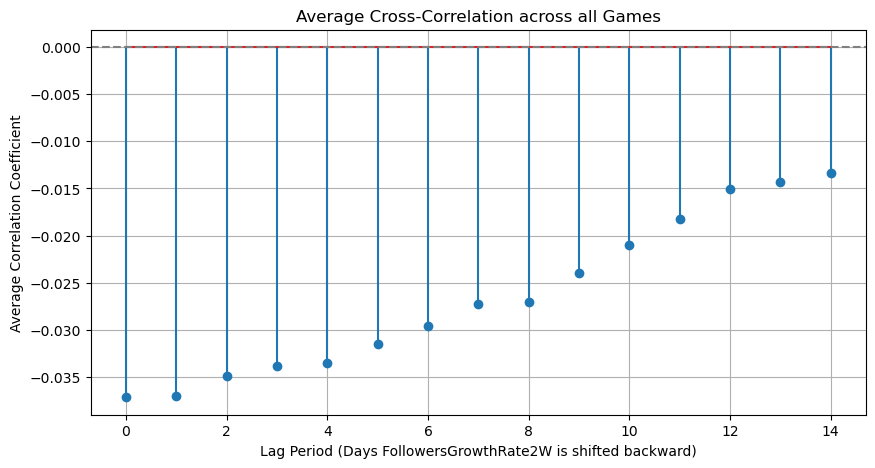


所有遊戲平均相關性最強的滯後期數為: Lag 0 天
您可以考慮將 Lag 0 的 FollowersGrowthRate2W 納入您的單一模型中。


In [8]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['FollowersGrowthRate2W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['FollowersGrowthRate2W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days FollowersGrowthRate2W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 FollowersGrowthRate2W 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0012

被 Lasso 選中的顯著滯後期數 (非零係數):
  GrowthRate_Lag_1: 係數 = -0.0047


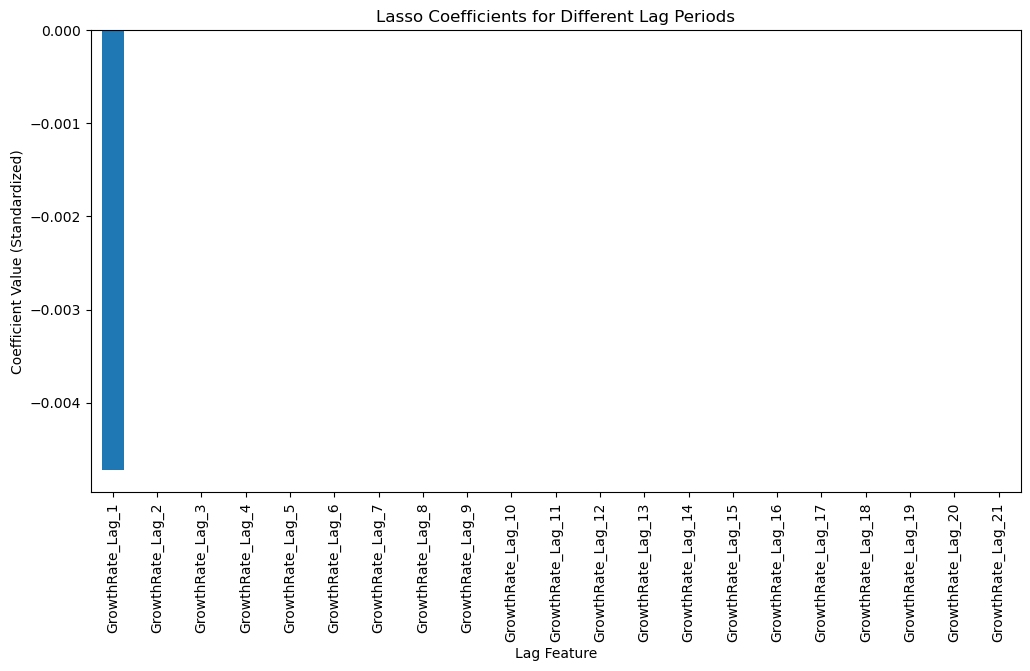

In [34]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['FollowersGrowthRate2W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### FollowersGrowthRate1M*

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_25624/1731172882.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)


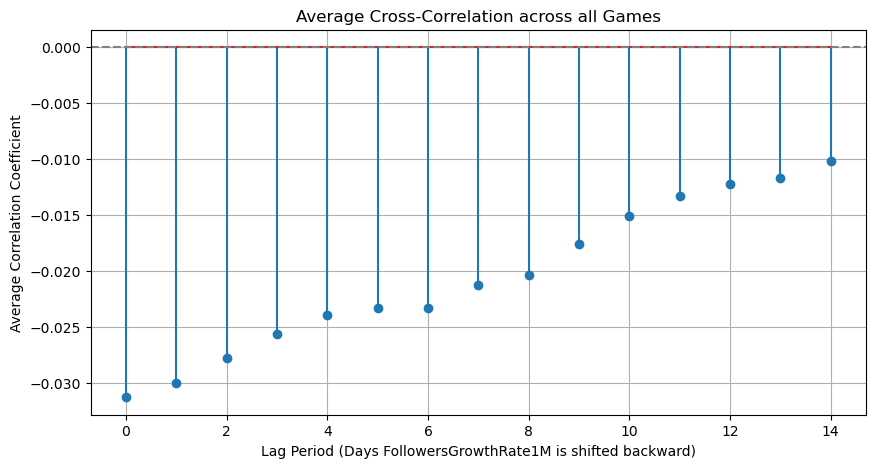


所有遊戲平均相關性最強的滯後期數為: Lag 0 天
您可以考慮將 Lag 0 的 FollowersGrowthRate1M 納入您的單一模型中。


In [9]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['FollowersGrowthRate1M']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['FollowersGrowthRate1M'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days FollowersGrowthRate1M is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 FollowersGrowthRate1M 納入您的單一模型中。")

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01098477895257588, tolerance: 0.006294839537869094
  model = cd_fast.enet_coordinate_descent_gram(
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012305542284096305, tolerance: 0.006294839537869094
  model = cd_fast.enet_coordinate_descent_gram(
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012570278492738396, tolerance: 0.006294839537869094
  model = cd_fast.enet_coordinate_descent_gram(
/Users/peijiefang/anaconda3/lib/pyt

LassoCV 找到的最佳 alpha 值: 0.0002

被 Lasso 選中的顯著滯後期數 (非零係數):
  GrowthRate_Lag_1: 係數 = -0.0101
  GrowthRate_Lag_11: 係數 = 0.0030
  GrowthRate_Lag_17: 係數 = 0.0027


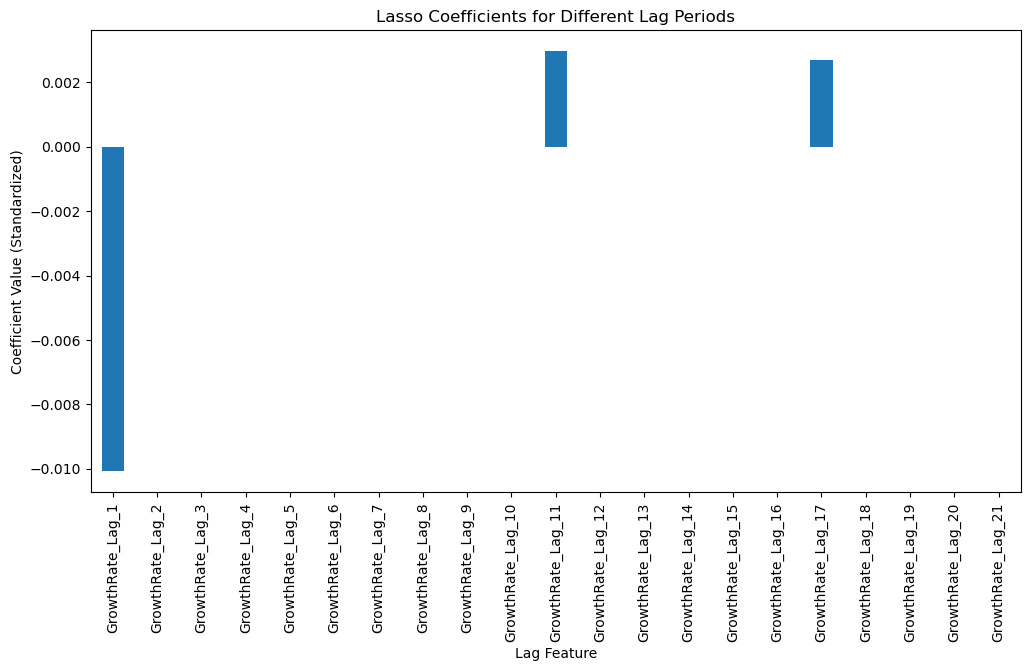

In [35]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['FollowersGrowthRate1M'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### PositiveRateGrowthRate1W

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_25624/3926037033.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)


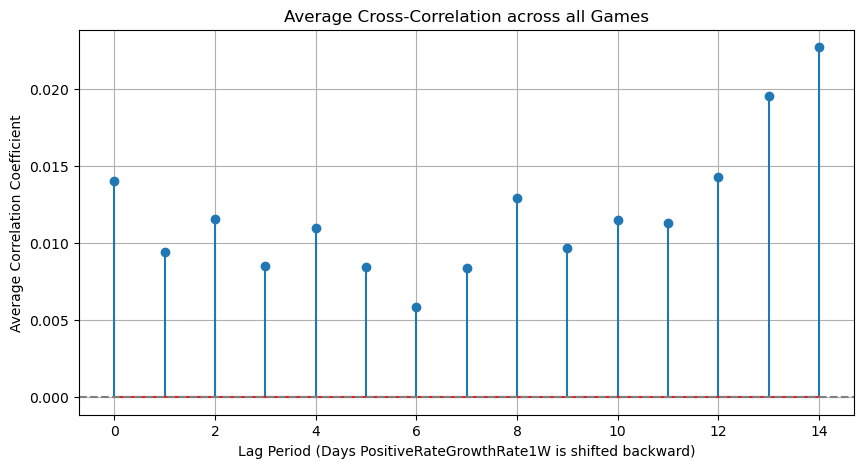


所有遊戲平均相關性最強的滯後期數為: Lag 14 天
您可以考慮將 Lag 14 的 PositiveRateGrowthRate1W 納入您的單一模型中。


In [11]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['PositiveRateGrowthRate1W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['PositiveRateGrowthRate1W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days PositiveRateGrowthRate1W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 PositiveRateGrowthRate1W 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0022

被 Lasso 選中的顯著滯後期數 (非零係數):
  GrowthRate_Lag_15: 係數 = 0.0004
  GrowthRate_Lag_17: 係數 = 0.0001


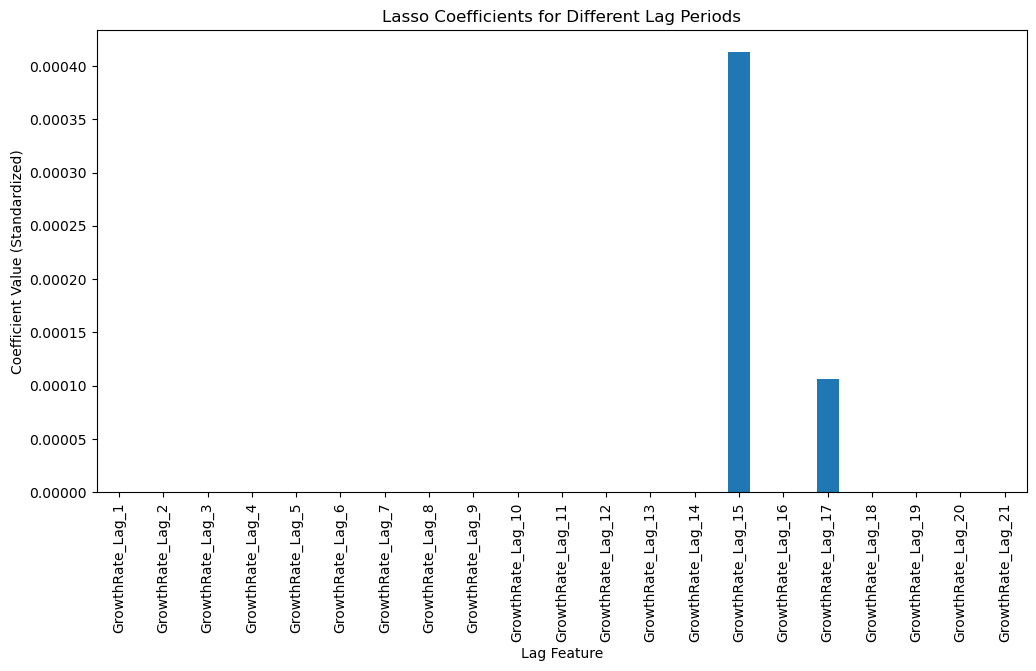

In [36]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['PositiveRateGrowthRate1W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### PositiveRateGrowthRate2W*

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_25624/1910004537.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)


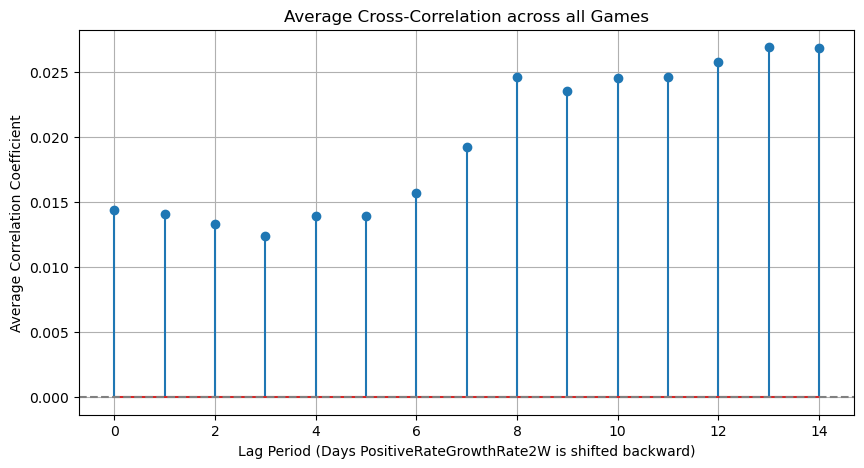


所有遊戲平均相關性最強的滯後期數為: Lag 13 天
您可以考慮將 Lag 13 的 PositiveRateGrowthRate2W 納入您的單一模型中。


In [12]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['PositiveRateGrowthRate2W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['PositiveRateGrowthRate2W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days PositiveRateGrowthRate2W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 PositiveRateGrowthRate2W 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0020

被 Lasso 選中的顯著滯後期數 (非零係數):
  GrowthRate_Lag_15: 係數 = 0.0008


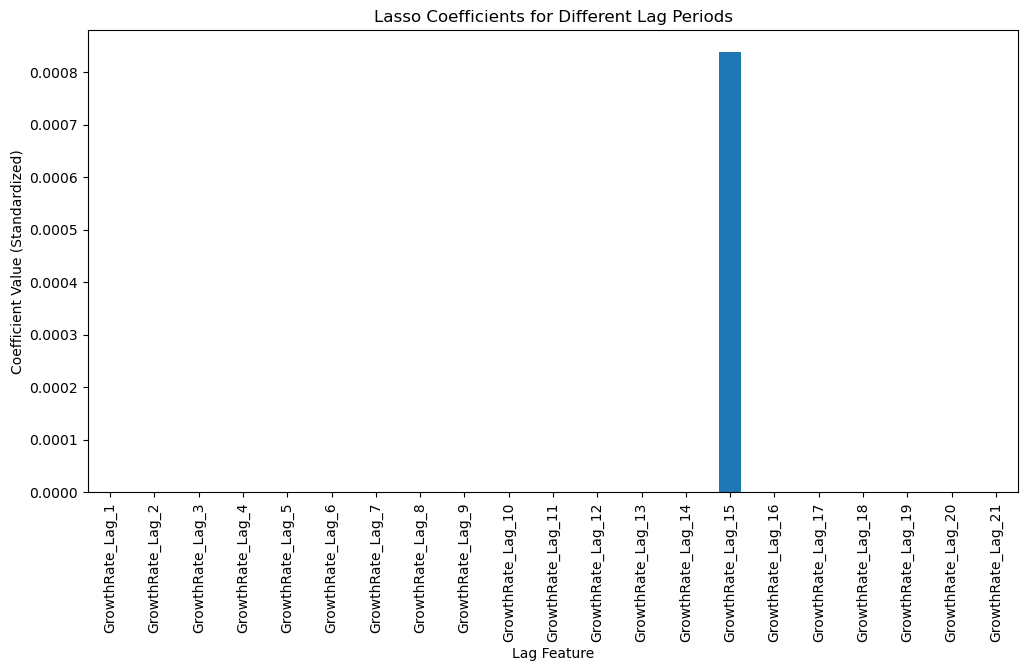

In [37]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['PositiveRateGrowthRate2W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### PositiveRateGrowthRate1M

/var/folders/hj/kj1rrf6n1977cn22dk_rt5lw0000gn/T/ipykernel_25624/1636474540.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)


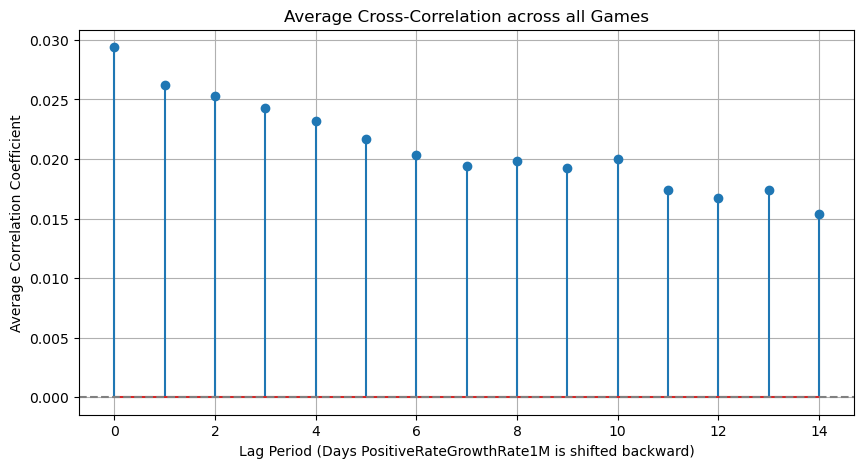


所有遊戲平均相關性最強的滯後期數為: Lag 0 天
您可以考慮將 Lag 0 的 PositiveRateGrowthRate1M 納入您的單一模型中。


In [13]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['PositiveRateGrowthRate1M']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['PositiveRateGrowthRate1M'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days PositiveRateGrowthRate1M is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 PositiveRateGrowthRate1M 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0015

被 Lasso 選中的顯著滯後期數 (非零係數):
  GrowthRate_Lag_1: 係數 = 0.0008
  GrowthRate_Lag_13: 係數 = 0.0000


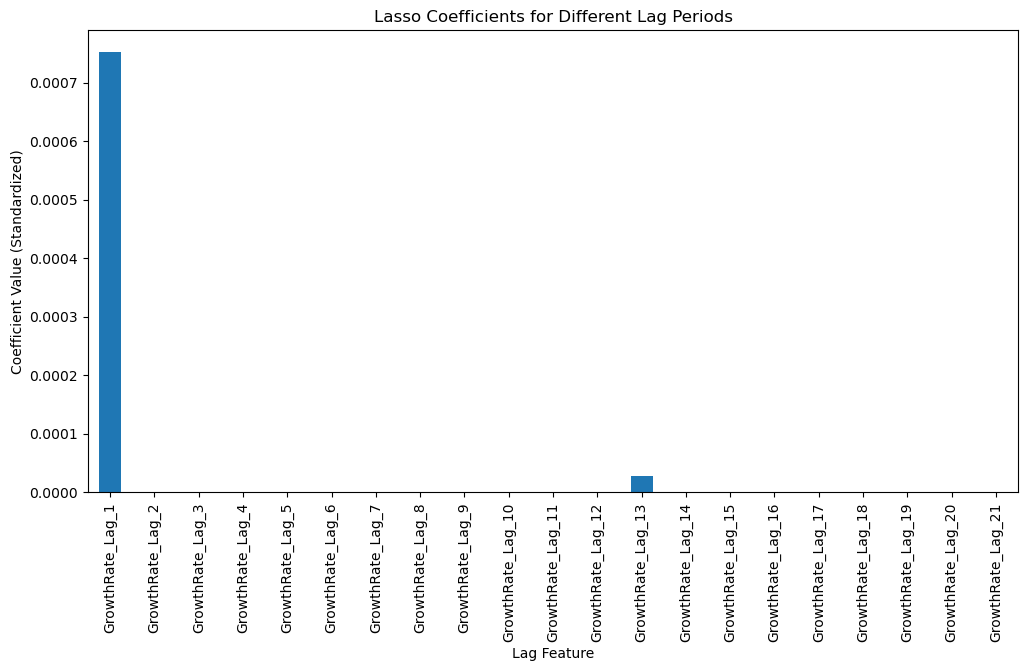

In [38]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['PositiveRateGrowthRate1M'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### DLC_sum_1W

找到 28 個遊戲資料。開始分析...


/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/pei

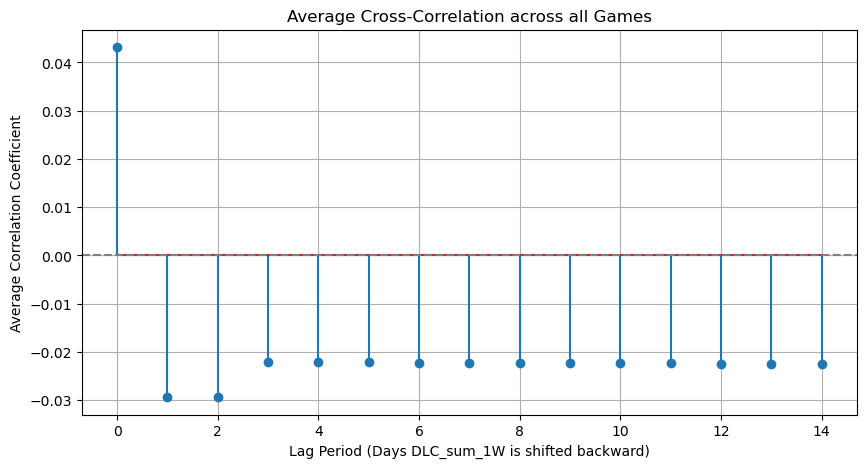


所有遊戲平均相關性最強的滯後期數為: Lag 0 天
您可以考慮將 Lag 0 的 DLC_sum_1W 納入您的單一模型中。


In [14]:
lag_results = {}

print(f"找到 {len(game_ids)} 個遊戲資料。開始分析...")

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['DLC_sum_1W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['DLC_sum_1W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days DLC_sum_1W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 DLC_sum_1W 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0013

被 Lasso 選中的顯著滯後期數 (非零係數):
沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。


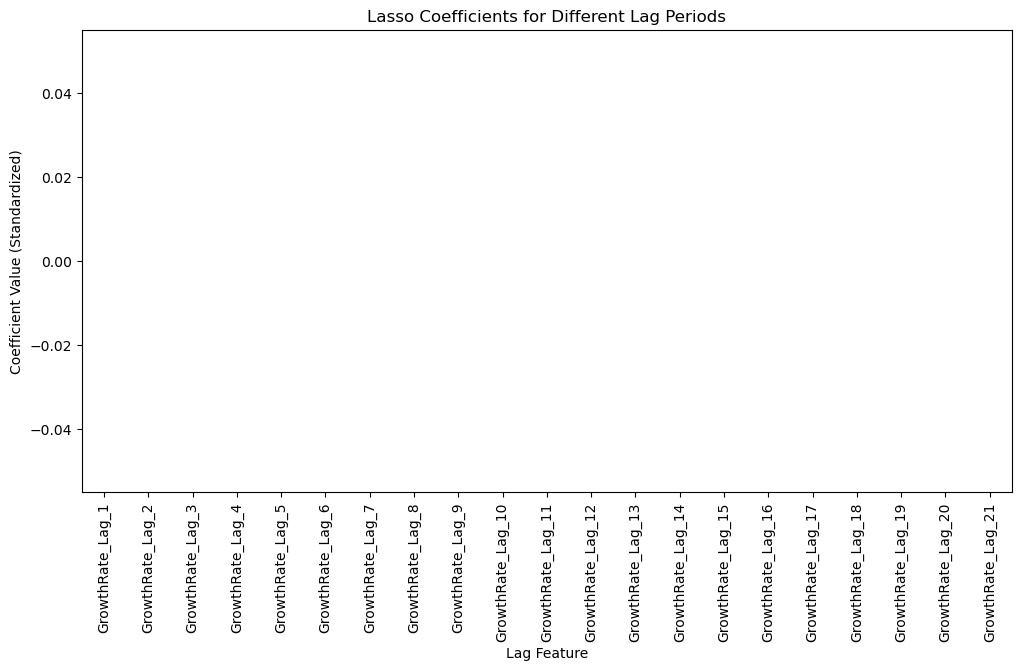

In [43]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['DLC_sum_1W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### DLC_sum_2W

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/pei

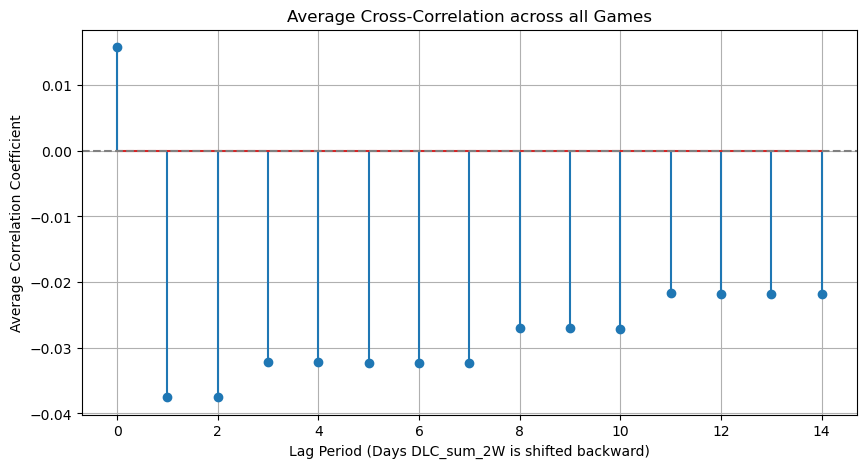


所有遊戲平均相關性最強的滯後期數為: Lag 2 天
您可以考慮將 Lag 2 的 DLC_sum_2W 納入您的單一模型中。


In [15]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['DLC_sum_2W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['DLC_sum_2W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days DLC_sum_2W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 DLC_sum_2W 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0015

被 Lasso 選中的顯著滯後期數 (非零係數):
沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。


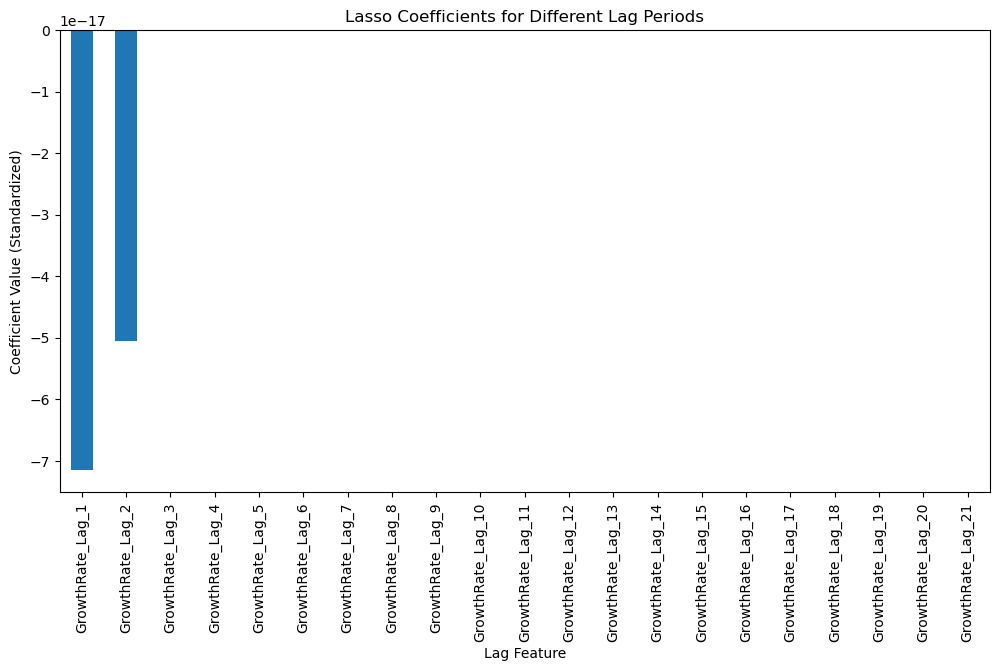

In [44]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['DLC_sum_2W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### DLC_sum_1M

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/pei

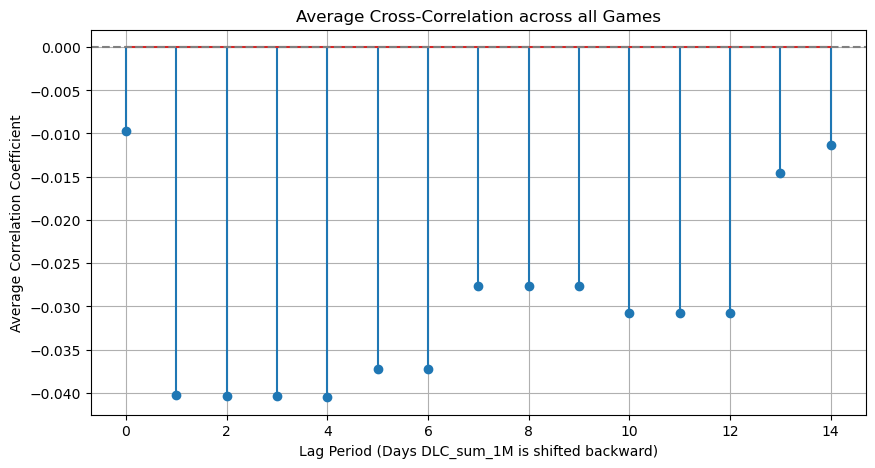


所有遊戲平均相關性最強的滯後期數為: Lag 4 天
您可以考慮將 Lag 4 的 DLC_sum_1M 納入您的單一模型中。


In [16]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['DLC_sum_1M']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['DLC_sum_1M'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days DLC_sum_1M is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 DLC_sum_1M 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0013

被 Lasso 選中的顯著滯後期數 (非零係數):
沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。


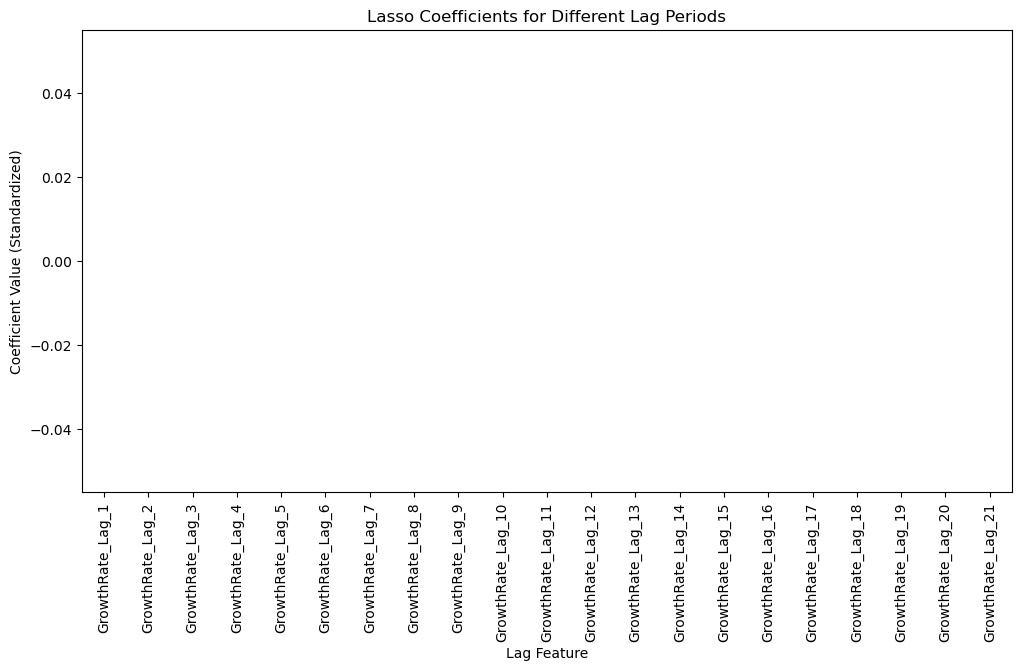

In [45]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['DLC_sum_1M'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### Sequel_sum_1W

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/pei

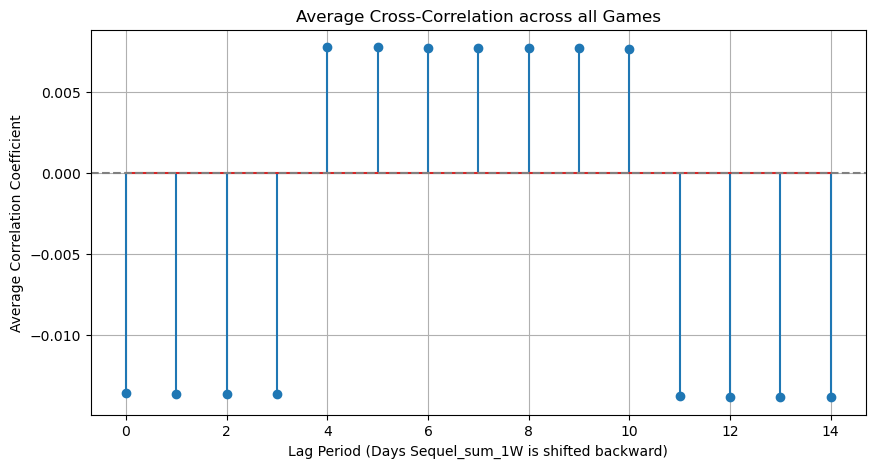


所有遊戲平均相關性最強的滯後期數為: Lag 14 天
您可以考慮將 Lag 14 的 Sequel_sum_1W 納入您的單一模型中。


In [17]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['Sequel_sum_1W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['Sequel_sum_1W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days Sequel_sum_1W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 Sequel_sum_1W 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0007

被 Lasso 選中的顯著滯後期數 (非零係數):
沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。


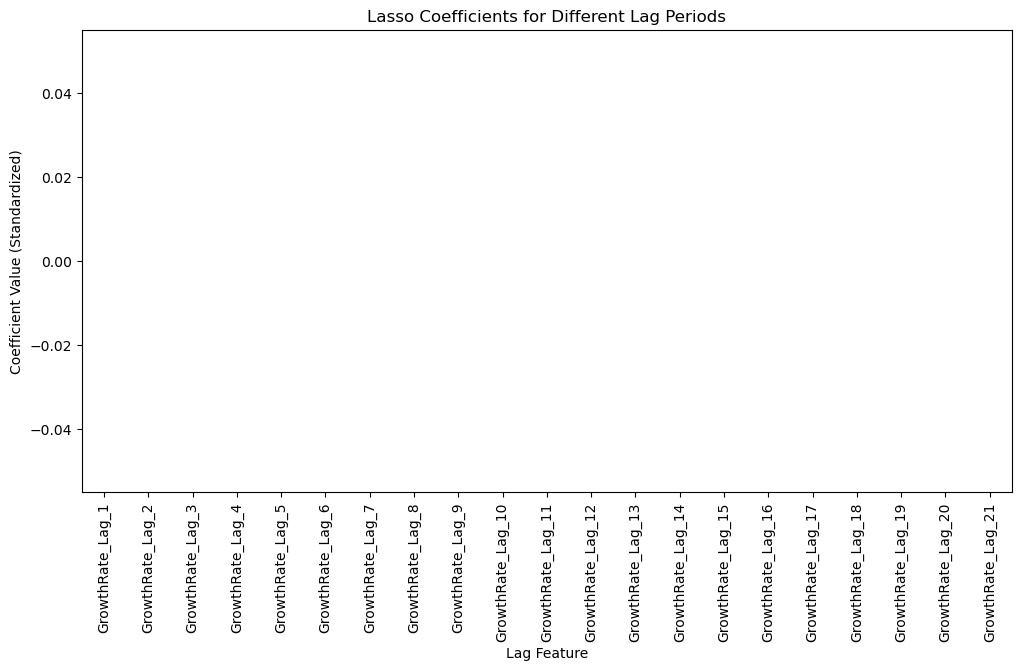

In [46]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['Sequel_sum_1W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### Sequel_sum_2W

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/pei

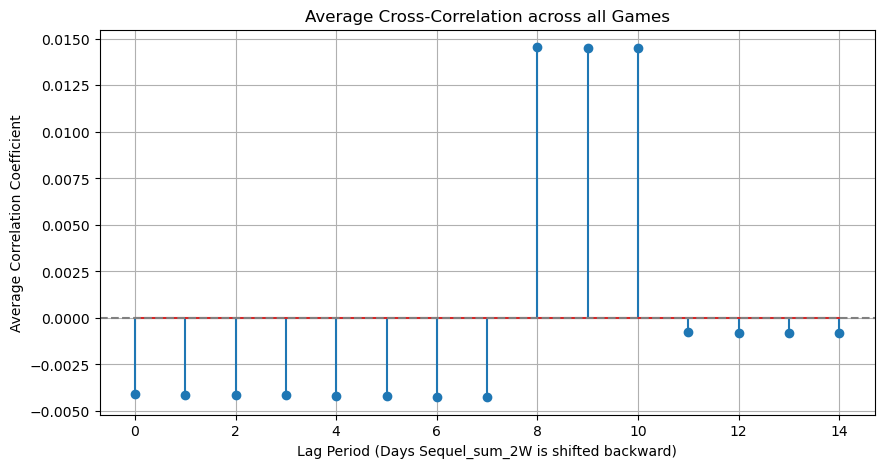


所有遊戲平均相關性最強的滯後期數為: Lag 8 天
您可以考慮將 Lag 8 的 Sequel_sum_2W 納入您的單一模型中。


In [18]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['Sequel_sum_2W']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['Sequel_sum_2W'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days Sequel_sum_2W is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 Sequel_sum_2W 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0008

被 Lasso 選中的顯著滯後期數 (非零係數):
沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。


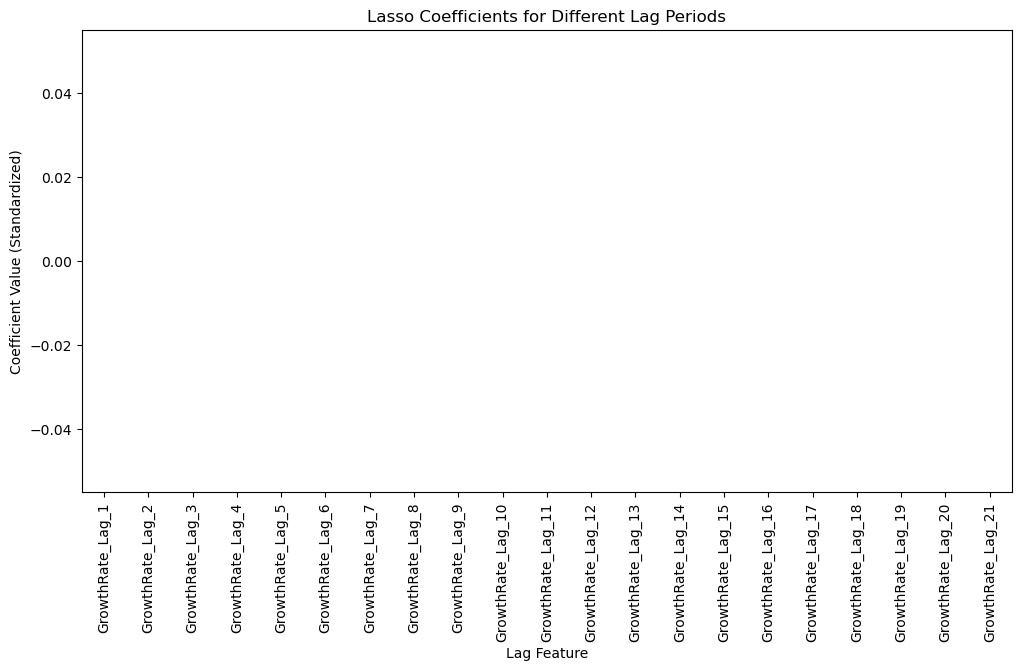

In [47]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['Sequel_sum_2W'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()

### Sequel_sum_1M

/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/peijiefang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/pei

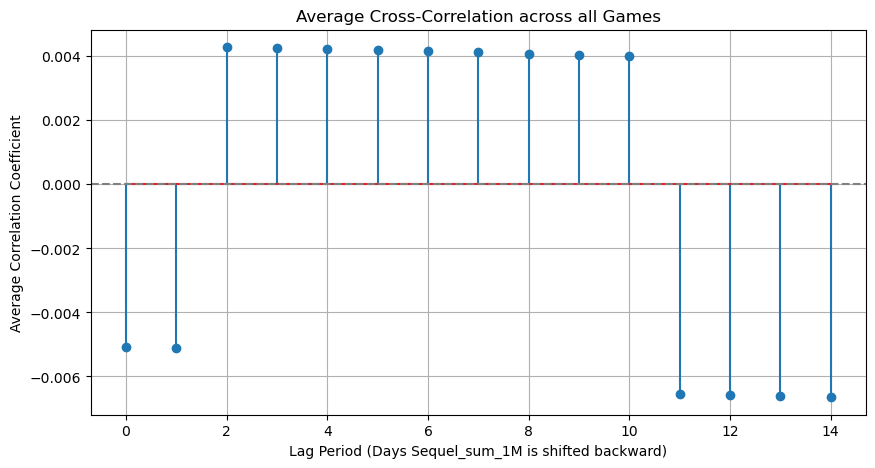


所有遊戲平均相關性最強的滯後期數為: Lag 14 天
您可以考慮將 Lag 14 的 Sequel_sum_1M 納入您的單一模型中。


In [19]:
lag_results = {}

# --------------------------------------------------
# 2. 分遊戲計算不同滯後期數下的相關性
# --------------------------------------------------
for game_id in game_ids:
    lag_results[game_id] = {}
    # 過濾出單一遊戲的資料
    game_data = df[df['GameID'] == game_id]
    
    ts_y = game_data['DiscountOrNot']
    ts_x = game_data['Sequel_sum_1M']

    for lag in range(max_lag + 1):
        # 滯後 X 變數
        lagged_x = ts_x.shift(lag)
        
        # 將 Y 和滯後的 X 組合，並刪除 NaN
        combined_df = pd.concat([ts_y, lagged_x], axis=1).dropna()
        
        if not combined_df.empty:
            # 計算皮爾遜相關係數
            corr = combined_df['DiscountOrNot'].corr(combined_df['Sequel_sum_1M'])
            lag_results[game_id][lag] = corr
        else:
            lag_results[game_id][lag] = np.nan

# --------------------------------------------------
# 3. 匯總結果：計算所有遊戲在每個滯後期數的平均相關性
# --------------------------------------------------
corr_df = pd.DataFrame(lag_results).T

# 計算每個滯後期數的平均相關性
average_correlations = corr_df.mean(axis=0)

# --------------------------------------------------
# 4. 視覺化結果並決定最佳滯後期數
# --------------------------------------------------
plt.figure(figsize=(10, 5))
# 使用 stem plot 展示相關性
plt.stem(average_correlations.index, average_correlations.values, use_line_collection=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Average Cross-Correlation across all Games')
plt.xlabel('Lag Period (Days Sequel_sum_1M is shifted backward)')
plt.ylabel('Average Correlation Coefficient')
plt.grid(True)
plt.show()

# 找出平均相關性最強的滯後期數
best_avg_lag = average_correlations.abs().idxmax()
print(f"\n所有遊戲平均相關性最強的滯後期數為: Lag {best_avg_lag} 天")
print(f"您可以考慮將 Lag {best_avg_lag} 的 Sequel_sum_1M 納入您的單一模型中。")

LassoCV 找到的最佳 alpha 值: 0.0003

被 Lasso 選中的顯著滯後期數 (非零係數):
沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。


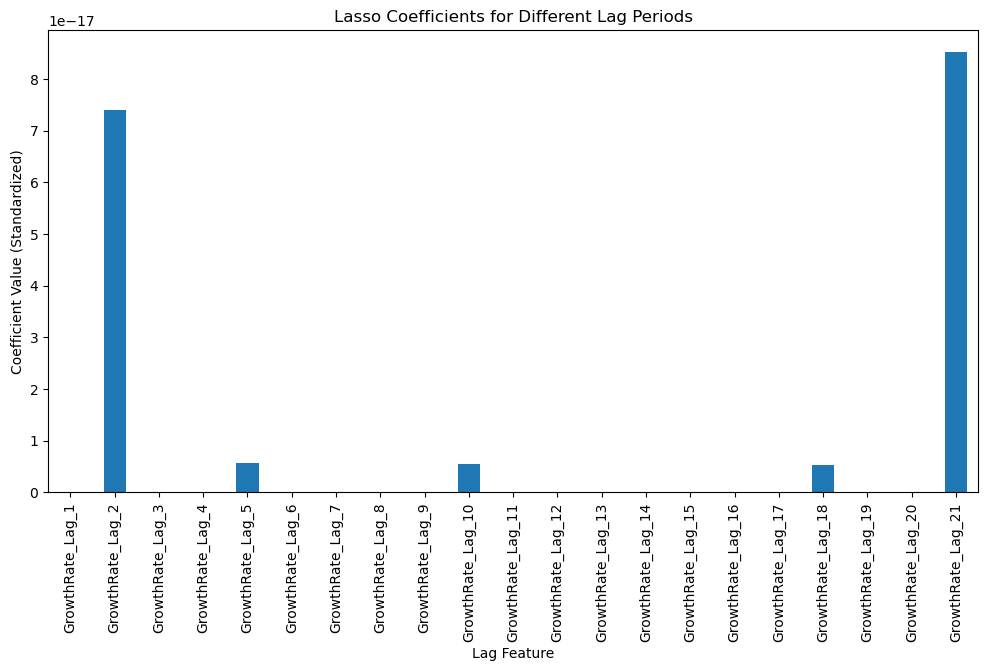

In [48]:
df['DiscountOrNot'] = df['DiscountOrNot'].astype(int)

# --------------------------------------------------
# 1. 特徵工程：生成所有潛在的滯後特徵
# --------------------------------------------------
max_lag_to_test = 21 # 測試最長 3 週的滯後期數
features_list = []

for lag in range(1, max_lag_to_test + 1):
    feature_name = f'GrowthRate_Lag_{lag}'
    # 按 GameID 分組，確保滯後是在各遊戲內部進行
    df[feature_name] = df.groupby('GameID')['Sequel_sum_1M'].shift(lag)
    features_list.append(feature_name)

# 移除因滯後產生的 NaN 值
df_model = df.dropna()

# 準備 X (特徵矩陣) 和 Y (目標變數)
X = df_model[features_list]
y = df_model['DiscountOrNot']

# --------------------------------------------------
# 2. 資料標準化 (Lasso 對標準化敏感)
# --------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. 使用 LassoCV 自動選擇最佳 alpha 並擬合模型
# --------------------------------------------------
# LassoCV 使用內建的交叉驗證來找到最佳的 alpha (懲罰強度)
# TimeSeriesSplit 確保交叉驗證保持時間順序
tscv = TimeSeriesSplit(n_splits=5) 
lasso_model = LassoCV(cv=tscv, random_state=42, selection='cyclic', max_iter=10000)
lasso_model.fit(X_scaled, y)

print(f"LassoCV 找到的最佳 alpha 值: {lasso_model.alpha_:.4f}")

# --------------------------------------------------
# 4. 解讀結果：識別被選中的滯後期數
# --------------------------------------------------
print("\n被 Lasso 選中的顯著滯後期數 (非零係數):")

selected_lags = []
# 獲取標準化後的係數
coefficients = pd.Series(lasso_model.coef_, index=features_list)

# 設定一個閾值來判斷係數是否足夠接近零 (Lasso 使得許多係數為精確的零)
threshold = 1e-5

for lag_name, coef in coefficients.items():
    if abs(coef) > threshold:
        print(f"  {lag_name}: 係數 = {coef:.4f}")
        selected_lags.append(lag_name)

if not selected_lags:
    print("沒有滯後期數被選中，這可能表示成長率特徵預測力較弱。")

# --------------------------------------------------
# 5. 視覺化係數
# --------------------------------------------------
plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar')
plt.title('Lasso Coefficients for Different Lag Periods')
plt.xlabel('Lag Feature')
plt.ylabel('Coefficient Value (Standardized)')
plt.show()